In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Récupération des images et préparation de la dataset

In [ ]:
# Chemin vers le dossier principal contenant les sous-dossiers

main_folder = '/content/drive/MyDrive/MMU-Iris-Database'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_data_labels(main_folder):

    """Fais un jeu de données sur MMU-Iris-Database avec en target ["left", "right"]"""

    X = []
    y = []

    for target_folder in os.listdir(main_folder):
        target_path = os.path.join(main_folder, target_folder)
        if os.path.isdir(target_path):
            for folder in os.listdir(target_path): # Pour fichier dans 1, 2, 3... (gauche / droite)
                side_path = os.path.join(target_path, folder)
                if os.path.isdir(side_path):
                    for image_filename in os.listdir(side_path):
                        if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                            image_path = os.path.join(side_path, image_filename)
                            target = folder # target = gauche ou droite
                            image = cv2.imread(image_path)
                            X.append(image)
                            y.append(target)
    return X, y

X, y = get_data_labels(main_folder)

In [ ]:
labelEnc = preprocessing.LabelEncoder()
y_enc = labelEnc.fit_transform(y)

In [ ]:
# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 5,
    brightness_range = (0.8, 1.1),
    zoom_range = (0.9, 1),
    fill_mode = "nearest",
)

In [ ]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
def augment_dataset(X_train, y_train, nb_aug_imgs):

  """
  Retourne un ndarray d'images augmentées utilisant 'datagen' (l'instance
  de la classe ImageDataGenerator) et leurs labels associés.
  """

  # Convertit les ndarray en listes
  if isinstance(X_train, np.ndarray):
    X_train = X_train.tolist()
  if isinstance(y_train, np.ndarray):
    y_train = y_train.tolist()

  augmented_images = []
  augmented_labels = []

  for img, label in zip(X_train, y_train):
    # Ajoute une dimension supplémentaire au Tensor
    # img = cv2.resize(img, (240, 320, 3))
    img = np.expand_dims(img, axis=0)
    # img = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
    # Compte le nombre d'itérations de la boucle
    batches = 0
    # Applique le ImageDataGenerator à l'image
    augmented_images.append(img)
    augmented_labels.append(label)
    for batch in datagen.flow(img, batch_size=1):

        augmented_images.append(batch)
        augmented_labels.append(label)
        batches += 1
        # Generer un nombre d'images puis sortir de la boucle
        if batches >= nb_aug_imgs:
          break

  augmented_images = np.array(augmented_images)
  print(augmented_images.shape)
  augmented_labels = np.array(augmented_labels)

  return augmented_images, augmented_labels

augmented_images_train, augmented_labels_train = augment_dataset(X_train, y_train_enc, 2)
augmented_images_test, augmented_labels_test = augment_dataset(X_test, y_test_enc, 2)


(1080, 1, 240, 320, 3)
(270, 1, 240, 320, 3)


In [ ]:
augmented_images_train = augmented_images_train.reshape((augmented_images_train.shape[0],augmented_images_train.shape[2],
                                augmented_images_train.shape[3],augmented_images_train.shape[4]))
augmented_images_test = augmented_images_test.reshape((augmented_images_test.shape[0],augmented_images_test.shape[2],
                                augmented_images_test.shape[3],augmented_images_test.shape[4]))


In [ ]:
augmented_images_train.shape

(1080, 240, 320, 3)

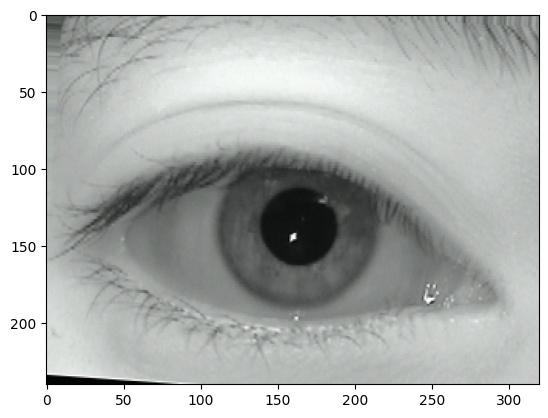

In [ ]:
plt.imshow(augmented_images_train[19].astype("uint8"))

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
from tensorflow.keras import layers
img_shape = (240, 320, 3)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_shape[0], img_shape[1], crop_to_aspect_ratio=True),
  layers.Rescaling(1./255, input_shape=img_shape)
])

In [ ]:
NBCLASSES = 2
IMSIZE=[240,320]


vgg = VGG16(input_shape = IMSIZE + [3], weights = 'imagenet', include_top = False)

# Freeze existing VGG already trained weights
for layer in vgg[:-2]:

    layer.trainable = False


side_eye_classifier = tf.keras.Sequential([
# Ajout de la couche de prétraitement
resize_and_rescale,
# Ajout des couches VGG16
vgg,
layers.Flatten(),
# Ajout de la couche de sortie comprenant autant de neurones que nos classes cibles
# C'est cette couches qui sera entrainée sur nos images d'entrainement
layers.Dense(2, activation='softmax')
], name="side_eye_classifier")

# Add new dense layer at the end

side_eye_classifier.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# Montrer l'architecture du modèle et le nombre de paramètres entrainables
side_eye_classifier.build(input_shape=(None, IMSIZE[0], IMSIZE[1], 3))
side_eye_classifier.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "side_eye_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 240, 320, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 35840)             0         
                                                                 
 dense (Dense)               (None, 2)                 71682     
                                                                 
Total params: 14,786,370
Trainable params: 71,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
tf.config.run_functions_eagerly(True)
hist = side_eye_classifier.fit(X_traintest, y_train_enc, batch_size = 60, epochs = 30, validation_split = 0.25, callbacks = [rlrop, early])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
5/5 [==============================] - 51s 7s/step - loss: 1.9740 - accuracy: 0.5111 - val_loss: 1.5127 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 10s 2s/step - loss: 0.8147 - accuracy: 0.6407 - val_loss: 0.4701 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 9s 2s/step - loss: 0.4228 - accuracy: 0.7963 - val_loss: 0.3349 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 9s 2s/step - loss: 0.2258 - accuracy: 0.9074 - val_loss: 0.5007 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 9s 2s/step - loss: 0.1655 - accuracy: 0.9556 - val_loss: 0.3495 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 9s 2s/step - loss: 0.1841 - accuracy: 0.9444 - val_loss: 0.3180 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 9s 2s/step - loss: 0.1233 - accuracy: 0.9741 - v

In [ ]:
# Exemple de données de test (remplacez cela par vos propres données)

y_test_pred = [np.argmax(v) for v in side_eye_classifier.predict(np.array(X_test))]  # Prédictions du modèle


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 15s 3s/step


In [ ]:
augmented_labels_test = np.argmax(augmented_labels_test, axis = 1)

[1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,


Matrice de confusion :
Précision : 0.98
Rappel : 0.98
Score F1 : 0.98
Exactitude : 0.98
[[43  2]
 [ 0 45]]


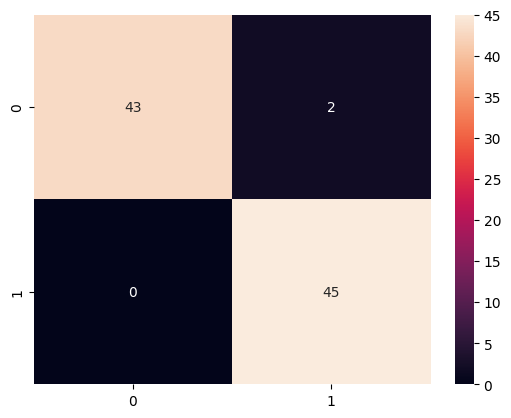

In [ ]:
import seaborn as sn
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred,average='macro')
recall = recall_score(y_test, y_test_pred,average='macro')
f1 = f1_score(y_test, y_test_pred,average='macro')

print("Matrice de confusion :")
sn.heatmap(conf_matrix, annot = True)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))
print(conf_matrix)

In [ ]:
side_eye_classifier.save("/content/drive/MyDrive/models.hdf5")